# Set Path

In [71]:
import numpy as np
import os
import random
import time
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score


In [40]:
base_path = "data/training_data/"

class_dirs = ['immune', 'tumour', 'stromal', 'other']

def ensure_dir_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)

random.seed(3888)
np.random.seed(3888)

# Resizing

In [41]:
def load_resize(img_path, size=(224, 224)):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(size)
    return np.array(img)

# Blur

In [42]:
def apply_blur(images, blur_radius=1):
    blurred = []
    for img in images:
        blurred_img = cv2.GaussianBlur(img, (blur_radius*2+1, blur_radius*2+1), 0)
        blurred.append(blurred_img)
    return np.array(blurred)

# Contrast

In [43]:
def adjust_contrast(images, factor=1.5):
    adjusted = []
    for img in images:
        pil_img = Image.fromarray(img)
        enhancer = ImageEnhance.Contrast(pil_img)
        contrasted = enhancer.enhance(factor)
        adjusted.append(np.array(contrasted))
    return np.array(adjusted)

# Split and train

In [44]:
def get_image_paths(base_path, class_dirs):
    image_paths = {'tumour': [], 'immune': [], 'stromal': [], 'other': []}
    for class_dir in class_dirs:
        dir_path = os.path.join(base_path, class_dir)
        if os.path.isdir(dir_path):
            for file_name in os.listdir(dir_path):
                if file_name.endswith(".png"):
                    image_paths[class_dir].append(os.path.join(dir_path, file_name))
    return image_paths

In [45]:
image_paths = get_image_paths(base_path, class_dirs)

all_images = []
all_labels = []

for label, paths in image_paths.items():
    for img_path in paths:
        all_images.append(img_path)
        all_labels.append(label)

# Shuffle the data
data = list(zip(all_images, all_labels))
random.shuffle(data)

all_images, all_labels = zip(*data)

# Splitting data into training, validation, and testing
training_size = 2500
val_size = 500
testing_size = 1000

X_train = np.array([load_resize(img_path) for img_path in all_images[:training_size]])
X_val = np.array([load_resize(img_path) for img_path in all_images[training_size:training_size+val_size]])
X_test = np.array([load_resize(img_path) for img_path in all_images[training_size+val_size:training_size+val_size+testing_size]])

# Encoding labels
le = LabelEncoder()
y_train = le.fit_transform(all_labels[:training_size])
y_val = le.transform(all_labels[training_size:training_size+val_size])
y_test = le.transform(all_labels[training_size+val_size:training_size+val_size+testing_size])


In [46]:
def build_model():
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Model Training

In [47]:
model = build_model()
early_stop = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

y_pred = np.argmax(model.predict(X_test), axis=1)

report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
accuracy = accuracy_score(y_test, y_pred)

results_row = {
    "Model": "original",
    "Accuracy": accuracy,
    "Precision_tumour": report["tumour"]["precision"],
    "Precision_immune": report["immune"]["precision"],
    "Precision_stromal": report["stromal"]["precision"],
    "Precision_other": report["other"]["precision"],
    "F1_score_macro": report["macro avg"]["f1-score"]
}

csv_path = "model_evaluation_summary.csv"
if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)
    updated_df = pd.concat([existing_df, pd.DataFrame([results_row])], ignore_index=True)
else:
    updated_df = pd.DataFrame([results_row])

updated_df.to_csv(csv_path, index=False)

print(updated_df.tail(1))

model.save("cnn_original.h5")

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 394s 10s/step - accuracy: 0.4216 - loss: 1.3473 - val_accuracy: 0.2420 - val_loss: 4.9457
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 388s 10s/step - accuracy: 0.5369 - loss: 1.0574 - val_accuracy: 0.2420 - val_loss: 3.3286
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 357s 9s/step - accuracy: 0.5770 - loss: 0.9996 - val_accuracy: 0.2800 - val_loss: 2.2325
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 305s 8s/step - accuracy: 0.5789 - loss: 0.9724 - val_accuracy: 0.2760 - val_loss: 1.6995
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 289s 7s/step - accuracy: 0.5949 - loss: 0.9652 - val_accuracy: 0.4380 - val_loss: 1.3152
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 395s 10s/step - accuracy: 0.6139 - loss: 0.9291 - val_accuracy: 0.4120 - val_loss: 1.3179
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 381s 10s/step - accuracy: 0.6461 - loss: 0.9013 - val_accuracy: 0.5400 - val_loss: 1.1299
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 340s 8s/step - accuracy: 0.6359 - loss: 0.9260 - val_accuracy: 0.5100

      Model  Accuracy  Precision_tumour  Precision_immune  Precision_stromal  \
0  original     0.651          0.638484          0.685106           0.577778   

   Precision_other  F1_score_macro  
0         0.756579        0.644298  


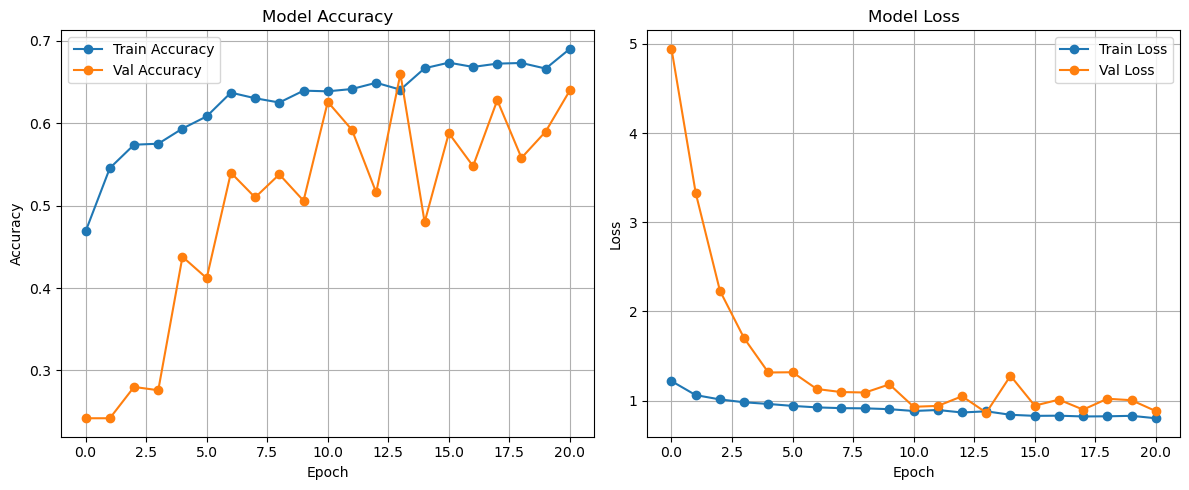

In [48]:
# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Original

In [77]:
model = load_model("cnn_original.h5")

y_probs_original = model.predict(X_test)
y_pred_original = np.argmax(y_probs_original, axis=1)

accuracy_original = accuracy_score(y_test, y_pred_original)

report_original = classification_report(
    y_test, y_pred_original, target_names=le.classes_, output_dict=True
)

confidence_overall = np.mean(np.max(y_probs_original, axis=1))

confidence_per_class = {}
for class_idx, class_name in enumerate(le.classes_):
    class_mask = (y_test == class_idx) & (y_pred_original == class_idx)
    if np.sum(class_mask) > 0:
        confidence_per_class[class_name] = np.mean(
            y_probs_original[class_mask, class_idx]
        )
    else:
        confidence_per_class[class_name] = np.nan

results_row_original = {
    "Model": "original",
    "Accuracy": accuracy_original,
    "F1_score": report_original["macro avg"]["f1-score"],
    "Confidence_overall": confidence_overall,
}

for class_name in le.classes_:
    results_row_original[f"Precision_{class_name}"] = report_original[class_name]["precision"]
    results_row_original[f"F1_{class_name}"] = report_original[class_name]["f1-score"]
    results_row_original[f"Confidence_{class_name}"] = confidence_per_class[class_name]

csv_path = "model_evaluation_summary.csv"
if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)
    existing_df = existing_df[existing_df["Model"] != "original"]
    updated_df = pd.concat([existing_df, pd.DataFrame([results_row_original])], ignore_index=True)
else:
    updated_df = pd.DataFrame([results_row_original])

updated_df.to_csv(csv_path, index=False)
print(updated_df.tail(1))


32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 568ms/step
      Model  Accuracy  Precision_tumour  Precision_immune  Precision_stromal  \
0  original     0.651          0.638484          0.685106           0.577778   

   Precision_other  F1_score  Confidence_overall  F1_immune  \
0         0.756579  0.644298            0.622687   0.632613   

   Confidence_immune  F1_other  Confidence_other  F1_stromal  \
0           0.662757  0.598958          0.611412    0.607004   

   Confidence_stromal  F1_tumour  Confidence_tumour  
0            0.666107   0.738617           0.684328  


/var/folders/lj/fqrtz_bn6rz7l33yfzrvjymw0000gn/T/ipykernel_23812/2078538001.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  updated_df = pd.concat([existing_df, pd.DataFrame([results_row_original])], ignore_index=True)


# Blur Testing

### Blur 1

In [78]:
X_test_blur1 = apply_blur(X_test, blur_radius=1)

model = load_model("cnn_original.h5")

y_probs_blur1 = model.predict(X_test_blur1)
y_pred_blur1 = np.argmax(y_probs_blur1, axis=1)

accuracy_blur1 = accuracy_score(y_test, y_pred_blur1)

report_blur1 = classification_report(
    y_test, y_pred_blur1, target_names=le.classes_, output_dict=True
)

confidence_overall = np.mean(np.max(y_probs_blur1, axis=1))

confidence_per_class = {}
for class_idx, class_name in enumerate(le.classes_):
    class_mask = (y_test == class_idx) & (y_pred_blur1 == class_idx)
    if np.sum(class_mask) > 0:
        confidence_per_class[class_name] = np.mean(
            y_probs_blur1[class_mask, class_idx]
        )
    else:
        confidence_per_class[class_name] = np.nan

results_row_blur1 = {
    "Model": "blur_1",
    "Accuracy": accuracy_blur1,
    "F1_score": report_blur1["macro avg"]["f1-score"],
    "Confidence_overall": confidence_overall,
}

for class_name in le.classes_:
    results_row_blur1[f"Precision_{class_name}"] = report_blur1[class_name]["precision"]
    results_row_blur1[f"F1_{class_name}"] = report_blur1[class_name]["f1-score"]
    results_row_blur1[f"Confidence_{class_name}"] = confidence_per_class[class_name]

csv_path = "model_evaluation_summary.csv"
if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)
    updated_df = pd.concat([existing_df, pd.DataFrame([results_row_blur1])], ignore_index=True)
else:
    updated_df = pd.DataFrame([results_row_blur1])

updated_df.to_csv(csv_path, index=False)
print(updated_df.tail(1))

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 653ms/step
    Model  Accuracy  Precision_tumour  Precision_immune  Precision_stromal  \
1  blur_1     0.629          0.589147          0.622896           0.622549   

   Precision_other  F1_score  Confidence_overall  F1_immune  \
1         0.794643  0.612062            0.632392   0.647986   

   Confidence_immune  F1_other  Confidence_other  F1_stromal  \
1           0.707388  0.517442          0.619952    0.566964   

   Confidence_stromal  F1_tumour  Confidence_tumour  
1            0.649627   0.715856           0.697521  


### Blur 3

In [79]:
X_test_blur3 = apply_blur(X_test, blur_radius=3)

model = load_model("cnn_original.h5")

y_probs_blur3 = model.predict(X_test_blur3)
y_pred_blur3 = np.argmax(y_probs_blur3, axis=1)

accuracy_blur3 = accuracy_score(y_test, y_pred_blur3)

report_blur3 = classification_report(
    y_test, y_pred_blur3, target_names=le.classes_, output_dict=True
)

confidence_overall = np.mean(np.max(y_probs_blur3, axis=1))

confidence_per_class = {}
for class_idx, class_name in enumerate(le.classes_):
    class_mask = (y_test == class_idx) & (y_pred_blur3 == class_idx)
    if np.sum(class_mask) > 0:
        confidence_per_class[class_name] = np.mean(
            y_probs_blur3[class_mask, class_idx]
        )
    else:
        confidence_per_class[class_name] = np.nan

results_row_blur3 = {
    "Model": "blur_3",
    "Accuracy": accuracy_blur3,
    "F1_score": report_blur3["macro avg"]["f1-score"],
    "Confidence_overall": confidence_overall,
}

for class_name in le.classes_:
    results_row_blur3[f"Precision_{class_name}"] = report_blur3[class_name]["precision"]
    results_row_blur3[f"F1_{class_name}"] = report_blur3[class_name]["f1-score"]
    results_row_blur3[f"Confidence_{class_name}"] = confidence_per_class[class_name]

csv_path = "model_evaluation_summary.csv"
if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)
    updated_df = pd.concat([existing_df, pd.DataFrame([results_row_blur3])], ignore_index=True)
else:
    updated_df = pd.DataFrame([results_row_blur3])

updated_df.to_csv(csv_path, index=False)
print(updated_df.tail(1))

32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 579ms/step
    Model  Accuracy  Precision_tumour  Precision_immune  Precision_stromal  \
2  blur_3     0.611          0.549161          0.591837           0.705479   

   Precision_other  F1_score  Confidence_overall  F1_immune  \
2         0.808511  0.584786            0.648277   0.658023   

   Confidence_immune  F1_other  Confidence_other  F1_stromal  \
2           0.722642  0.466258          0.644764    0.528205   

   Confidence_stromal  F1_tumour  Confidence_tumour  
2            0.633478   0.686657           0.710763  


### Blur 5

In [80]:
X_test_blur5 = apply_blur(X_test, blur_radius=5)

model = load_model("cnn_original.h5")

y_probs_blur5 = model.predict(X_test_blur5)
y_pred_blur5 = np.argmax(y_probs_blur5, axis=1)

accuracy_blur5 = accuracy_score(y_test, y_pred_blur5)

report_blur5 = classification_report(
    y_test, y_pred_blur5, target_names=le.classes_, output_dict=True
)

confidence_overall = np.mean(np.max(y_probs_blur5, axis=1))

confidence_per_class = {}
for class_idx, class_name in enumerate(le.classes_):
    class_mask = (y_test == class_idx) & (y_pred_blur5 == class_idx)
    if np.sum(class_mask) > 0:
        confidence_per_class[class_name] = np.mean(
            y_probs_blur5[class_mask, class_idx]
        )
    else:
        confidence_per_class[class_name] = np.nan

results_row_blur5 = {
    "Model": "blur_5",
    "Accuracy": accuracy_blur5,
    "F1_score": report_blur5["macro avg"]["f1-score"],
    "Confidence_overall": confidence_overall,
}

for class_name in le.classes_:
    results_row_blur5[f"Precision_{class_name}"] = report_blur5[class_name]["precision"]
    results_row_blur5[f"F1_{class_name}"] = report_blur5[class_name]["f1-score"]
    results_row_blur5[f"Confidence_{class_name}"] = confidence_per_class[class_name]

csv_path = "model_evaluation_summary.csv"
if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)
    updated_df = pd.concat([existing_df, pd.DataFrame([results_row_blur5])], ignore_index=True)
else:
    updated_df = pd.DataFrame([results_row_blur5])

updated_df.to_csv(csv_path, index=False)
print(updated_df.tail(1))

32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 574ms/step
    Model  Accuracy  Precision_tumour  Precision_immune  Precision_stromal  \
3  blur_5     0.603          0.526316          0.610592           0.708333   

   Precision_other  F1_score  Confidence_overall  F1_immune  \
3         0.765306   0.57718            0.650771   0.658824   

   Confidence_immune  F1_other  Confidence_other  F1_stromal  \
3           0.710838  0.454545          0.672797    0.525773   

   Confidence_stromal  F1_tumour  Confidence_tumour  
3            0.612667   0.669578           0.720602  


### Blur 7

In [81]:
X_test_blur7 = apply_blur(X_test, blur_radius=7)

model = load_model("cnn_original.h5")

y_probs_blur7 = model.predict(X_test_blur7)
y_pred_blur7 = np.argmax(y_probs_blur7, axis=1)

accuracy_blur7 = accuracy_score(y_test, y_pred_blur7)

report_blur7 = classification_report(
    y_test, y_pred_blur7, target_names=le.classes_, output_dict=True
)

confidence_overall = np.mean(np.max(y_probs_blur7, axis=1))

confidence_per_class = {}
for class_idx, class_name in enumerate(le.classes_):
    class_mask = (y_test == class_idx) & (y_pred_blur7 == class_idx)
    if np.sum(class_mask) > 0:
        confidence_per_class[class_name] = np.mean(
            y_probs_blur7[class_mask, class_idx]
        )
    else:
        confidence_per_class[class_name] = np.nan

results_row_blur7 = {
    "Model": "blur_7",
    "Accuracy": accuracy_blur7,
    "F1_score": report_blur7["macro avg"]["f1-score"],
    "Confidence_overall": confidence_overall,
}

for class_name in le.classes_:
    results_row_blur7[f"Precision_{class_name}"] = report_blur7[class_name]["precision"]
    results_row_blur7[f"F1_{class_name}"] = report_blur7[class_name]["f1-score"]
    results_row_blur7[f"Confidence_{class_name}"] = confidence_per_class[class_name]

csv_path = "model_evaluation_summary.csv"
if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)
    updated_df = pd.concat([existing_df, pd.DataFrame([results_row_blur7])], ignore_index=True)
else:
    updated_df = pd.DataFrame([results_row_blur7])

updated_df.to_csv(csv_path, index=False)
print(updated_df.tail(1))

32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 759ms/step
    Model  Accuracy  Precision_tumour  Precision_immune  Precision_stromal  \
4  blur_7     0.581          0.497863          0.599278           0.710345   

   Precision_other  F1_score  Confidence_overall  F1_immune  \
4         0.718182  0.560779            0.643125   0.602541   

   Confidence_immune  F1_other  Confidence_other  F1_stromal  \
4           0.693749  0.461988          0.700132    0.529563   

   Confidence_stromal  F1_tumour  Confidence_tumour  
4             0.60232   0.649025           0.718262  


### BLur 10

In [82]:
X_test_blur10 = apply_blur(X_test, blur_radius=10)

model = load_model("cnn_original.h5")

y_probs_blur10 = model.predict(X_test_blur10)
y_pred_blur10 = np.argmax(y_probs_blur10, axis=1)

accuracy_blur10 = accuracy_score(y_test, y_pred_blur10)

report_blur10 = classification_report(
    y_test, y_pred_blur10, target_names=le.classes_, output_dict=True
)

confidence_overall = np.mean(np.max(y_probs_blur10, axis=1))

confidence_per_class = {}
for class_idx, class_name in enumerate(le.classes_):
    class_mask = (y_test == class_idx) & (y_pred_blur10 == class_idx)
    if np.sum(class_mask) > 0:
        confidence_per_class[class_name] = np.mean(
            y_probs_blur10[class_mask, class_idx]
        )
    else:
        confidence_per_class[class_name] = np.nan

results_row_blur10 = {
    "Model": "blur_10",
    "Accuracy": accuracy_blur10,
    "F1_score": report_blur10["macro avg"]["f1-score"],
    "Confidence_overall": confidence_overall,
}

for class_name in le.classes_:
    results_row_blur10[f"Precision_{class_name}"] = report_blur10[class_name]["precision"]
    results_row_blur10[f"F1_{class_name}"] = report_blur10[class_name]["f1-score"]
    results_row_blur10[f"Confidence_{class_name}"] = confidence_per_class[class_name]

csv_path = "model_evaluation_summary.csv"
if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)
    updated_df = pd.concat([existing_df, pd.DataFrame([results_row_blur10])], ignore_index=True)
else:
    updated_df = pd.DataFrame([results_row_blur10])

updated_df.to_csv(csv_path, index=False)
print(updated_df.tail(1))

32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 601ms/step
     Model  Accuracy  Precision_tumour  Precision_immune  Precision_stromal  \
5  blur_10     0.538          0.438835          0.626316                0.7   

   Precision_other  F1_score  Confidence_overall  F1_immune  \
5         0.606897  0.525905            0.626271   0.512931   

   Confidence_immune  F1_other  Confidence_other  F1_stromal  \
5           0.643515  0.466844          0.723162    0.532995   

   Confidence_stromal  F1_tumour  Confidence_tumour  
5            0.597668    0.59085           0.698843  


# Contrast Testing

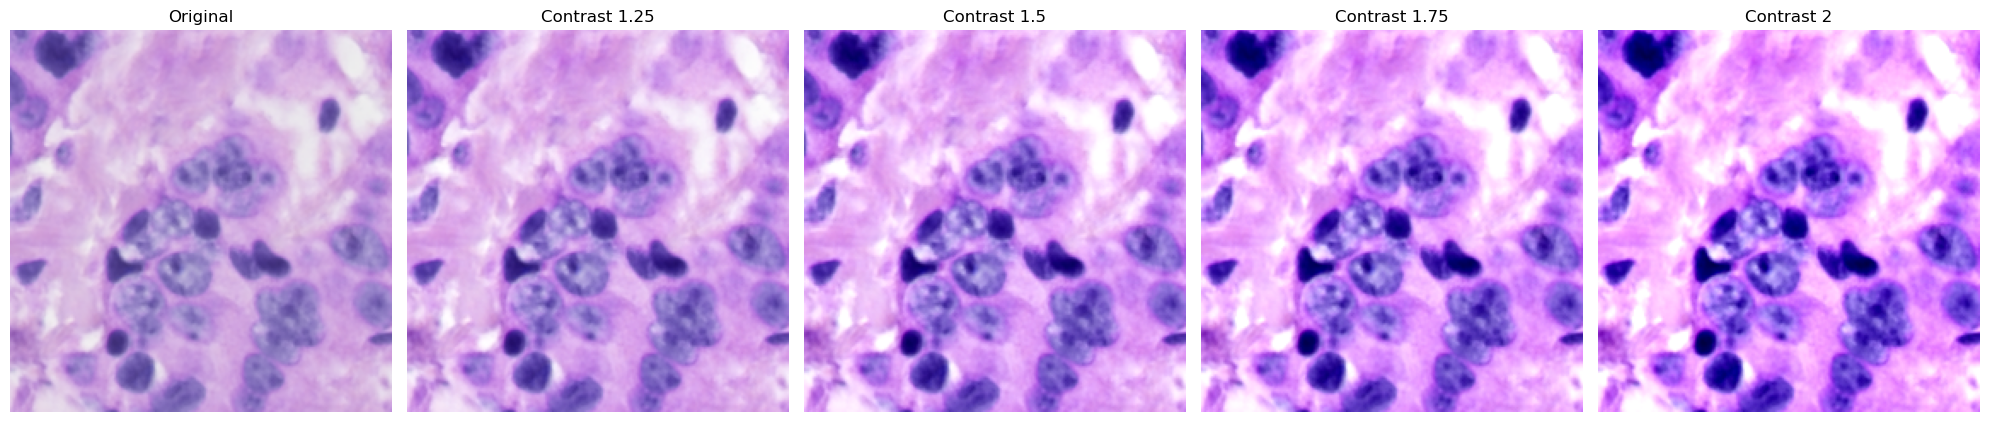

32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 763ms/step

Logged: contrast 1.25
           Model  Accuracy  Precision_tumour  Precision_immune  \
6  contrast_1.25     0.333               1.0          0.574468   

   Precision_stromal  Precision_other  F1_score  Confidence_overall  \
6           0.279042         0.612069  0.256006            0.609735   

   F1_immune  Confidence_immune  F1_other  Confidence_other  F1_stromal  \
6   0.168224           0.586124  0.408046          0.549169    0.431881   

   Confidence_stromal  F1_tumour  Confidence_tumour  
6             0.70894   0.015873           0.520895  
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 584ms/step

Logged: contrast 1.5
          Model  Accuracy  Precision_tumour  Precision_immune  \
7  contrast_1.5     0.243               0.0               0.0   

   Precision_stromal  Precision_other  F1_score  Confidence_overall  \
7           0.243243              0.0  0.097747            0.805854   

   F1_immune Confidence_immune  F1_other Confidence_other  F1_

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageEnhance
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import os

# --- Contrast Adjustment Function ---
def adjust_contrast(images, factor=1.5):
    adjusted = []
    for img in images:
        pil_img = Image.fromarray(img)
        enhancer = ImageEnhance.Contrast(pil_img)
        contrasted = enhancer.enhance(factor)
        adjusted.append(np.array(contrasted))
    return np.array(adjusted)

# --- Load Model ---
model = load_model("cnn_original.h5")

# --- CSV Path ---
csv_path = "model_evaluation_summary.csv"

# --- Contrast Levels to Evaluate ---
contrast_factors = [1.25, 1.5, 1.75, 2]

# --- Pick a Random Image for Visualization ---
rand_index = random.randint(0, len(X_test) - 1)
original_img = X_test[rand_index]

# --- Show Contrast Variants of the Sample ---
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
axes[0].imshow(original_img.astype('uint8'))
axes[0].set_title("Original")
axes[0].axis('off')

for i, factor in enumerate(contrast_factors):
    contrasted_img = adjust_contrast([original_img], factor=factor)[0]
    axes[i+1].imshow(contrasted_img.astype('uint8'))
    axes[i+1].set_title(f"Contrast {factor}")
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

# --- Evaluate Each Contrast Level ---
for factor in contrast_factors:
    X_test_contrast = adjust_contrast(X_test, factor=factor)
    y_probs = model.predict(X_test_contrast)
    y_pred = np.argmax(y_probs, axis=1)

    report = classification_report(
        y_test,
        y_pred,
        target_names=le.classes_,
        output_dict=True,
        zero_division=0
    )
    accuracy = accuracy_score(y_test, y_pred)
    confidence_overall = np.mean(np.max(y_probs, axis=1))

    confidence_per_class = {}
    for class_idx, class_name in enumerate(le.classes_):
        class_mask = (y_test == class_idx) & (y_pred == class_idx)
        if np.sum(class_mask) > 0:
            confidence_per_class[class_name] = np.mean(y_probs[class_mask, class_idx])
        else:
            confidence_per_class[class_name] = "NA"

    results_row = {
        "Model": f"contrast_{factor}",
        "Accuracy": accuracy,
        "F1_score": report["macro avg"]["f1-score"],
        "Confidence_overall": confidence_overall
    }

    for class_name in le.classes_:
        results_row[f"Precision_{class_name}"] = report[class_name]["precision"]
        results_row[f"F1_{class_name}"] = report[class_name]["f1-score"]
        results_row[f"Confidence_{class_name}"] = confidence_per_class[class_name]

    # Append or create CSV
    if os.path.exists(csv_path):
        existing_df = pd.read_csv(csv_path)
        updated_df = pd.concat([existing_df, pd.DataFrame([results_row])], ignore_index=True)
    else:
        updated_df = pd.DataFrame([results_row])

    updated_df.fillna("NA", inplace=True)
    updated_df.to_csv(csv_path, index=False)

    print(f"\nLogged: contrast {factor}")
    print(updated_df.tail(1))

# Combination (Blur + Contrast)

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageEnhance
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import os
import cv2

# --- Load Trained Model ---
model = load_model("cnn_original.h5")

# --- CSV Path ---
csv_path = "model_evaluation_summary.csv"

# --- Define Blur and Contrast Factors ---
blur_factors = [1, 3, 5, 7, 10]
contrast_factors = [1.25, 1.5, 1.75, 2]

# --- Blur Function ---
def apply_blur(images, blur_radius=1):
    blurred = []
    for img in images:
        img_blurred = cv2.GaussianBlur(img, (blur_radius*2+1, blur_radius*2+1), 0)
        blurred.append(img_blurred)
    return np.array(blurred)

# --- Contrast Function ---
def adjust_contrast(images, factor=1.5):
    adjusted = []
    for img in images:
        pil_img = Image.fromarray(img)
        enhancer = ImageEnhance.Contrast(pil_img)
        contrasted = enhancer.enhance(factor)
        adjusted.append(np.array(contrasted))
    return np.array(adjusted)

# --- Loop Over All Blur and Contrast Combinations ---
for blur_factor in blur_factors:
    for contrast_factor in contrast_factors:
        # Apply blur and contrast
        X_test_blurred = apply_blur(X_test, blur_radius=blur_factor)
        X_test_contrasted = adjust_contrast(X_test_blurred, factor=contrast_factor)

        # Predict
        y_probs = model.predict(X_test_contrasted)
        y_pred = np.argmax(y_probs, axis=1)

        # Report and Accuracy
        report = classification_report(
            y_test, y_pred, target_names=le.classes_, output_dict=True, zero_division=0
        )
        accuracy = accuracy_score(y_test, y_pred)
        confidence_overall = np.mean(np.max(y_probs, axis=1))

        # Per-class Confidence
        confidence_per_class = {}
        for class_idx, class_name in enumerate(le.classes_):
            class_mask = (y_test == class_idx) & (y_pred == class_idx)
            if np.sum(class_mask) > 0:
                confidence_per_class[class_name] = np.mean(y_probs[class_mask, class_idx])
            else:
                confidence_per_class[class_name] = "NA"

        # Build Row
        results_row = {
            "Model": f"blur_{blur_factor}_contrast_{contrast_factor}",
            "Accuracy": accuracy,
            "F1_score": report["macro avg"]["f1-score"],
            "Confidence_overall": confidence_overall
        }

        for class_name in le.classes_:
            results_row[f"Precision_{class_name}"] = report[class_name]["precision"]
            results_row[f"F1_{class_name}"] = report[class_name]["f1-score"]
            results_row[f"Confidence_{class_name}"] = confidence_per_class[class_name]

        # Save to CSV
        if os.path.exists(csv_path):
            existing_df = pd.read_csv(csv_path)
            updated_df = pd.concat([existing_df, pd.DataFrame([results_row])], ignore_index=True)
        else:
            updated_df = pd.DataFrame([results_row])

        updated_df.fillna("NA", inplace=True)
        updated_df.to_csv(csv_path, index=False)

        print(f"\nLogged: blur_{blur_factor}_contrast_{contrast_factor}")
        print(updated_df.tail(1))

32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 765ms/step

Logged: blur_1_contrast_1.25
                   Model  Accuracy  Precision_tumour  Precision_immune  \
10  blur_1_contrast_1.25     0.384               1.0          0.496689   

    Precision_stromal  Precision_other  F1_score  Confidence_overall  \
10           0.310984         0.589928  0.331466            0.561764   

    F1_immune Confidence_immune  F1_other Confidence_other  F1_stromal  \
10   0.352941          0.583278  0.442049         0.548218    0.461376   

    Confidence_stromal  F1_tumour Confidence_tumour  
10             0.66122   0.069498           0.41724  


/var/folders/lj/fqrtz_bn6rz7l33yfzrvjymw0000gn/T/ipykernel_23812/1612995497.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  updated_df.fillna("NA", inplace=True)


32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 615ms/step

Logged: blur_1_contrast_1.5
                  Model  Accuracy  Precision_tumour  Precision_immune  \
11  blur_1_contrast_1.5     0.244               0.0               0.4   

    Precision_stromal  Precision_other  F1_score  Confidence_overall  \
11           0.243216              0.0  0.101244             0.75398   

    F1_immune Confidence_immune  F1_other Confidence_other  F1_stromal  \
11   0.014337          0.502618       0.0               NA    0.390638   

    Confidence_stromal  F1_tumour Confidence_tumour  
11            0.769565        0.0                NA  


/var/folders/lj/fqrtz_bn6rz7l33yfzrvjymw0000gn/T/ipykernel_23812/1612995497.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  updated_df.fillna("NA", inplace=True)


32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 585ms/step

Logged: blur_1_contrast_1.75
                   Model  Accuracy  Precision_tumour  Precision_immune  \
12  blur_1_contrast_1.75     0.243               0.0               0.0   

    Precision_stromal  Precision_other  F1_score  Confidence_overall  \
12           0.243243              0.0  0.097747            0.878287   

    F1_immune Confidence_immune  F1_other Confidence_other  F1_stromal  \
12        0.0                NA       0.0               NA     0.39099   

    Confidence_stromal  F1_tumour Confidence_tumour  
12            0.852405        0.0                NA  
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 555ms/step

Logged: blur_1_contrast_2
                Model  Accuracy  Precision_tumour  Precision_immune  \
13  blur_1_contrast_2     0.243               0.0               0.0   

    Precision_stromal  Precision_other  F1_score  Confidence_overall  \
13           0.243243              0.0  0.097747            0.936378   

    F1_immune Confid

/var/folders/lj/fqrtz_bn6rz7l33yfzrvjymw0000gn/T/ipykernel_23812/1612995497.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  updated_df.fillna("NA", inplace=True)


32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 855ms/step

Logged: blur_3_contrast_1.5
                  Model  Accuracy  Precision_tumour  Precision_immune  \
15  blur_3_contrast_1.5     0.245               0.0             0.375   

    Precision_stromal  Precision_other  F1_score  Confidence_overall  \
15           0.243952              0.0  0.103216            0.682688   

    F1_immune Confidence_immune  F1_other Confidence_other  F1_stromal  \
15   0.021277          0.547005       0.0               NA    0.391586   

    Confidence_stromal  F1_tumour Confidence_tumour  
15            0.703195        0.0                NA  


/var/folders/lj/fqrtz_bn6rz7l33yfzrvjymw0000gn/T/ipykernel_23812/1612995497.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  updated_df.fillna("NA", inplace=True)


32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 592ms/step

Logged: blur_3_contrast_1.75
                   Model  Accuracy  Precision_tumour  Precision_immune  \
16  blur_3_contrast_1.75     0.243               0.0              0.25   

    Precision_stromal  Precision_other  F1_score  Confidence_overall  \
16           0.242972              0.0  0.099379             0.83415   

    F1_immune Confidence_immune  F1_other Confidence_other  F1_stromal  \
16   0.007194          0.490374       0.0               NA    0.390323   

    Confidence_stromal  F1_tumour Confidence_tumour  
16            0.805804        0.0                NA  


/var/folders/lj/fqrtz_bn6rz7l33yfzrvjymw0000gn/T/ipykernel_23812/1612995497.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  updated_df.fillna("NA", inplace=True)


32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 664ms/step

Logged: blur_3_contrast_2
                Model  Accuracy  Precision_tumour  Precision_immune  \
17  blur_3_contrast_2     0.242               0.0               0.0   

    Precision_stromal  Precision_other  F1_score  Confidence_overall  \
17           0.242485              0.0  0.097424            0.912059   

    F1_immune Confidence_immune  F1_other Confidence_other  F1_stromal  \
17        0.0                NA       0.0               NA    0.389694   

    Confidence_stromal  F1_tumour Confidence_tumour  
17            0.870058        0.0                NA  
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 601ms/step

Logged: blur_5_contrast_1.25
                   Model  Accuracy  Precision_tumour  Precision_immune  \
18  blur_5_contrast_1.25     0.512          0.753623          0.465558   

    Precision_stromal  Precision_other  F1_score  Confidence_overall  \
18           0.457143         0.615385  0.491829            0.541568   

    F1_immune Confid

/var/folders/lj/fqrtz_bn6rz7l33yfzrvjymw0000gn/T/ipykernel_23812/1612995497.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  updated_df.fillna("NA", inplace=True)


32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 590ms/step

Logged: blur_5_contrast_1.5
                  Model  Accuracy  Precision_tumour  Precision_immune  \
19  blur_5_contrast_1.5     0.263               0.0          0.571429   

    Precision_stromal  Precision_other  F1_score  Confidence_overall  \
19           0.248175         0.833333  0.141786            0.629646   

    F1_immune Confidence_immune  F1_other Confidence_other  F1_stromal  \
19    0.12945          0.548499  0.042017         0.446704    0.395677   

    Confidence_stromal  F1_tumour Confidence_tumour  
19            0.658512        0.0                NA  


/var/folders/lj/fqrtz_bn6rz7l33yfzrvjymw0000gn/T/ipykernel_23812/1612995497.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  updated_df.fillna("NA", inplace=True)


32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 591ms/step

Logged: blur_5_contrast_1.75
                   Model  Accuracy  Precision_tumour  Precision_immune  \
20  blur_5_contrast_1.75     0.244               0.0          0.333333   

    Precision_stromal  Precision_other  F1_score  Confidence_overall  \
20           0.243461              0.0   0.10131            0.797703   

    F1_immune Confidence_immune  F1_other Confidence_other  F1_stromal  \
20   0.014286          0.529968       0.0               NA    0.390953   

    Confidence_stromal  F1_tumour Confidence_tumour  
20            0.768099        0.0                NA  


/var/folders/lj/fqrtz_bn6rz7l33yfzrvjymw0000gn/T/ipykernel_23812/1612995497.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  updated_df.fillna("NA", inplace=True)


32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 555ms/step

Logged: blur_5_contrast_2
                Model  Accuracy  Precision_tumour  Precision_immune  \
21  blur_5_contrast_2     0.243               0.0          0.333333   

    Precision_stromal  Precision_other  F1_score  Confidence_overall  \
21           0.242728              0.0  0.099307            0.890294   

    F1_immune Confidence_immune  F1_other Confidence_other  F1_stromal  \
21    0.00722          0.496763       0.0               NA    0.390008   

    Confidence_stromal  F1_tumour Confidence_tumour  
21            0.843791        0.0                NA  


/var/folders/lj/fqrtz_bn6rz7l33yfzrvjymw0000gn/T/ipykernel_23812/1612995497.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  updated_df.fillna("NA", inplace=True)


32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 639ms/step

Logged: blur_7_contrast_1.25
                   Model  Accuracy  Precision_tumour  Precision_immune  \
22  blur_7_contrast_1.25     0.543          0.706422          0.493573   

    Precision_stromal  Precision_other  F1_score  Confidence_overall  \
22           0.521569          0.57085  0.532487            0.553165   

    F1_immune Confidence_immune  F1_other Confidence_other  F1_stromal  \
22   0.579186          0.654869  0.588727         0.607099    0.533066   

    Confidence_stromal  F1_tumour Confidence_tumour  
22            0.621819   0.428969          0.458307  


/var/folders/lj/fqrtz_bn6rz7l33yfzrvjymw0000gn/T/ipykernel_23812/1612995497.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  updated_df.fillna("NA", inplace=True)


32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 621ms/step

Logged: blur_7_contrast_1.5
                  Model  Accuracy  Precision_tumour  Precision_immune  \
23  blur_7_contrast_1.5     0.299               0.0              0.55   

    Precision_stromal  Precision_other  F1_score  Confidence_overall  \
23           0.257336         0.794118  0.213784            0.585852   

    F1_immune Confidence_immune  F1_other Confidence_other  F1_stromal  \
23   0.248588          0.579678  0.203008         0.467918     0.40354   

    Confidence_stromal  F1_tumour Confidence_tumour  
23            0.625042        0.0                NA  


/var/folders/lj/fqrtz_bn6rz7l33yfzrvjymw0000gn/T/ipykernel_23812/1612995497.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  updated_df.fillna("NA", inplace=True)


32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 552ms/step

Logged: blur_7_contrast_1.75
                   Model  Accuracy  Precision_tumour  Precision_immune  \
24  blur_7_contrast_1.75     0.245               0.0          0.428571   

    Precision_stromal  Precision_other  F1_score  Confidence_overall  \
24           0.243706              0.0  0.103155            0.760223   

    F1_immune Confidence_immune  F1_other Confidence_other  F1_stromal  \
24   0.021352          0.526735       0.0               NA    0.391269   

    Confidence_stromal  F1_tumour Confidence_tumour  
24            0.732753        0.0                NA  


/var/folders/lj/fqrtz_bn6rz7l33yfzrvjymw0000gn/T/ipykernel_23812/1612995497.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  updated_df.fillna("NA", inplace=True)


32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 548ms/step

Logged: blur_7_contrast_2
                Model  Accuracy  Precision_tumour  Precision_immune  \
25  blur_7_contrast_2     0.244               0.0               0.5   

    Precision_stromal  Precision_other  F1_score  Confidence_overall  \
25           0.242972              0.0  0.101178             0.86709   

    F1_immune Confidence_immune  F1_other Confidence_other  F1_stromal  \
25   0.014388          0.496294       0.0               NA    0.390323   

    Confidence_stromal  F1_tumour Confidence_tumour  
25            0.818293        0.0                NA  


/var/folders/lj/fqrtz_bn6rz7l33yfzrvjymw0000gn/T/ipykernel_23812/1612995497.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  updated_df.fillna("NA", inplace=True)


32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 587ms/step

Logged: blur_10_contrast_1.25
                    Model  Accuracy  Precision_tumour  Precision_immune  \
26  blur_10_contrast_1.25     0.574          0.635838          0.592058   

    Precision_stromal  Precision_other  F1_score  Confidence_overall  \
26           0.593886         0.510903  0.570889            0.555075   

    F1_immune Confidence_immune  F1_other Confidence_other  F1_stromal  \
26   0.595281          0.575154  0.593128         0.653628    0.575053   

    Confidence_stromal  F1_tumour Confidence_tumour  
26            0.617322   0.520095          0.498649  


/var/folders/lj/fqrtz_bn6rz7l33yfzrvjymw0000gn/T/ipykernel_23812/1612995497.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  updated_df.fillna("NA", inplace=True)


32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 552ms/step

Logged: blur_10_contrast_1.5
                   Model  Accuracy  Precision_tumour  Precision_immune  \
27  blur_10_contrast_1.5     0.372               0.0          0.596591   

    Precision_stromal  Precision_other  F1_score  Confidence_overall  \
27           0.281294          0.59292   0.31848            0.554671   

    F1_immune Confidence_immune  F1_other Confidence_other  F1_stromal  \
27   0.466667          0.583117  0.388406         0.559745    0.418848   

    Confidence_stromal  F1_tumour Confidence_tumour  
27            0.606582        0.0                NA  


/var/folders/lj/fqrtz_bn6rz7l33yfzrvjymw0000gn/T/ipykernel_23812/1612995497.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  updated_df.fillna("NA", inplace=True)


32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 549ms/step

Logged: blur_10_contrast_1.75
                    Model  Accuracy  Precision_tumour  Precision_immune  \
28  blur_10_contrast_1.75     0.253               0.0               0.7   

    Precision_stromal  Precision_other  F1_score  Confidence_overall  \
28           0.243878              0.0   0.12144            0.704244   

    F1_immune Confidence_immune  F1_other Confidence_other  F1_stromal  \
28   0.095238          0.540947       0.0               NA    0.390523   

    Confidence_stromal  F1_tumour Confidence_tumour  
28              0.6874        0.0                NA  


/var/folders/lj/fqrtz_bn6rz7l33yfzrvjymw0000gn/T/ipykernel_23812/1612995497.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  updated_df.fillna("NA", inplace=True)


32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 662ms/step

Logged: blur_10_contrast_2
                 Model  Accuracy  Precision_tumour  Precision_immune  \
29  blur_10_contrast_2     0.244               0.0               0.5   

    Precision_stromal  Precision_other  F1_score  Confidence_overall  \
29           0.242972              0.0  0.101178            0.829499   

    F1_immune Confidence_immune  F1_other Confidence_other  F1_stromal  \
29   0.014388          0.508762       0.0               NA    0.390323   

    Confidence_stromal  F1_tumour Confidence_tumour  
29            0.780621        0.0                NA  


/var/folders/lj/fqrtz_bn6rz7l33yfzrvjymw0000gn/T/ipykernel_23812/1612995497.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  updated_df.fillna("NA", inplace=True)


In [86]:
import pandas as pd

# Load the CSV
csv_path = "model_evaluation_summary.csv"
df = pd.read_csv(csv_path)

# Remove all rows where Model starts with "contrast"
df_cleaned = df[~df["Model"].str.startswith("contrast")]

# Drop the column named "F1_score_macro" if it exists
if "F1_score_macro" in df_cleaned.columns:
    df_cleaned = df_cleaned.drop(columns=["F1_score_macro"])

# Save the cleaned CSV
df_cleaned.to_csv(csv_path, index=False)

print("Removed all 'contrast' rows and 'F1_score_macro' column. Updated CSV saved.")

Removed all 'contrast' rows and 'F1_score_macro' column. Updated CSV saved.


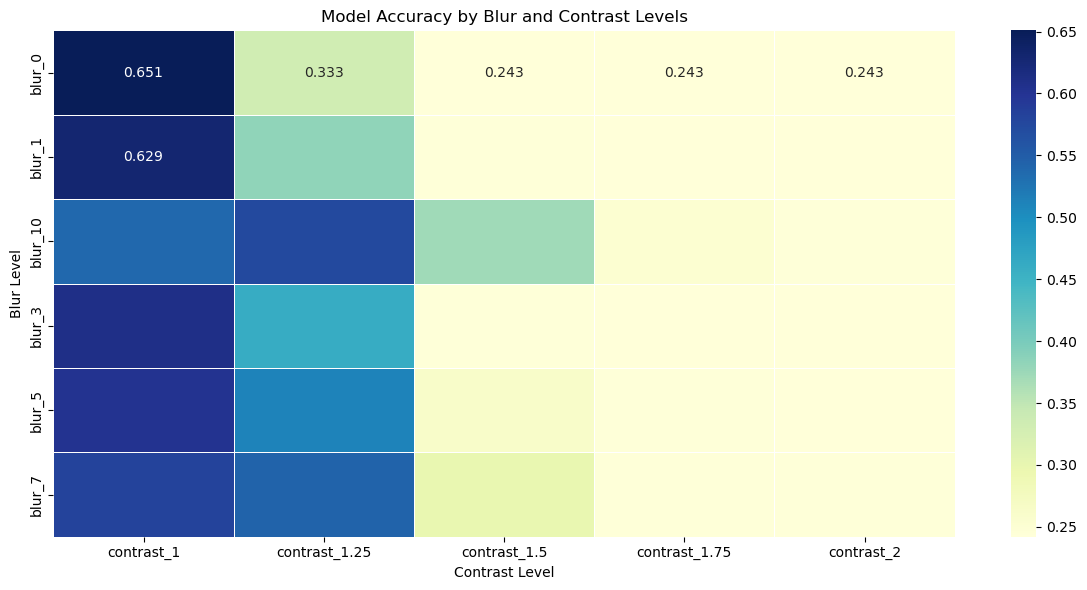

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load CSV file
df = pd.read_csv("model_evaluation_summary.csv")

# Extract blur and contrast levels
def parse_model_name(name):
    blur = "0"
    contrast = "1"
    if "blur" in name:
        blur = name.split("blur_")[1].split("_")[0]
    if "contrast" in name:
        contrast = name.split("contrast_")[1].split("_")[0]
    return f"blur_{blur}", f"contrast_{contrast}"

df["blur"], df["contrast"] = zip(*df["Model"].apply(parse_model_name))

# Pivot table for accuracy
pivot_table = df.pivot(index="blur", columns="contrast", values="Accuracy")

# Sort for consistent heatmap layout
pivot_table = pivot_table.sort_index().sort_index(axis=1)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt=".3f", linewidths=0.5)
plt.title("Model Accuracy by Blur and Contrast Levels")
plt.xlabel("Contrast Level")
plt.ylabel("Blur Level")
plt.tight_layout()
plt.show()
